<h1>Magnetic field azimuth in the plane-of-the-sky (POS)</h1>

This notebook walks you through the calculation of the magnetic field azimuth angle in the plane-of-the-sky using the weak field approximation. I generated two sets of Stokes spectra from a FALC atmosphere with the same constant magnetic field vector. The difference between the two runs is that in the second one, I turned off the magneto-optical (MO) effects in RH (the output directory is labelled with "noMO").

In [20]:
# First some imports
import matplotlib.pyplot as plt
import rhanalyze
import numpy as np
from rhanalyze.rhatmos import input_atmos
import glob
from numpy.polynomial import polynomial as P

In [21]:
# and some styling
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


In [22]:
# Name of RH output directory with spectra for magnetic field with transverse component
rhoutput = '/Users/rce/work/RH/rhf1d/run_Bt_200G_075_020'
# Name of RH output directory with same spectrum but without magneto-optical effects
rhoutput_noMO = '/Users/rce/work/RH/rhf1d/run_Bt_200G_075_020_noMO'

In [23]:
# Some constants of interest
lam0 = 8542.09  # central wavelength of the Ca II 8542 A line
# choose a wavelength to evaluate the local continuum (in Angs). This is just to get an arbitrary normalizing factor
wl_cont = 8530.0

KM_TO_M = 1.0E3


<h2> First read the RH ouput and plot the atmospheric variables</h2>

Model magnetic field at height index 0:
B =             200.0 gauss
Inclination =   75.0 deg
Azimuth =       20.0 deg
Btrans =        193.2 gauss


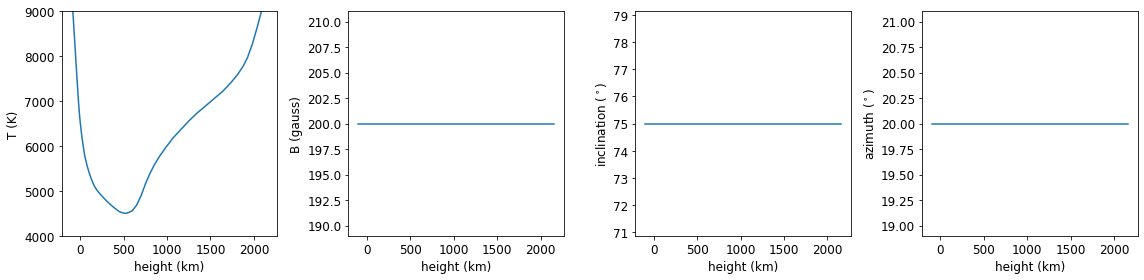

In [24]:
# Read output directory and plot the atmosphere

fig, ax = plt.subplots(1,4, figsize = (16, 4))
ax[0].set_ylim(4000, 9000)
ax[0].set_ylabel('T (K)')
ax[1].set_ylabel('B (gauss)')
ax[2].set_ylabel(r'inclination ($^\circ$)')
ax[3].set_ylabel(r'azimuth ($^\circ$)')
for jj in range(4):
    ax[jj].set_xlabel('height (km)')


# Read the input atmospheres from RH's output directory
falc = rhanalyze.rhout(rhoutput) 
height = falc.geometry.height/ KM_TO_M
tau500 = falc.geometry.tau500

# Plot the Temperature and magnetic field vector as a function of height
ax[0].plot(height, falc.atmos.T)
ax[1].plot(height, falc.atmos.B*10**4)
ax[2].plot(height, falc.atmos.gamma_B*180./np.pi)
ax[3].plot(height, falc.atmos.chi_B*180./np.pi)


plt.tight_layout()


B_mod = falc.atmos.B[0]*10**4
gamma_mod = falc.atmos.gamma_B[0]*180/np.pi
chi_mod = falc.atmos.chi_B[0]*180/np.pi
Bt_mod = B_mod * np.sin(falc.atmos.gamma_B[0])
print('Model magnetic field at height index 0:')
print('B =             ' + format(B_mod, '4.1f') + ' gauss')
print('Inclination =   ' + format(gamma_mod, '4.1f') + ' deg')
print('Azimuth =       ' + format(chi_mod, '4.1f') + ' deg')
print('Btrans =        ' + format(Bt_mod, '4.1f') + ' gauss')

<h2> Plot  I, Q, U and V</h2>

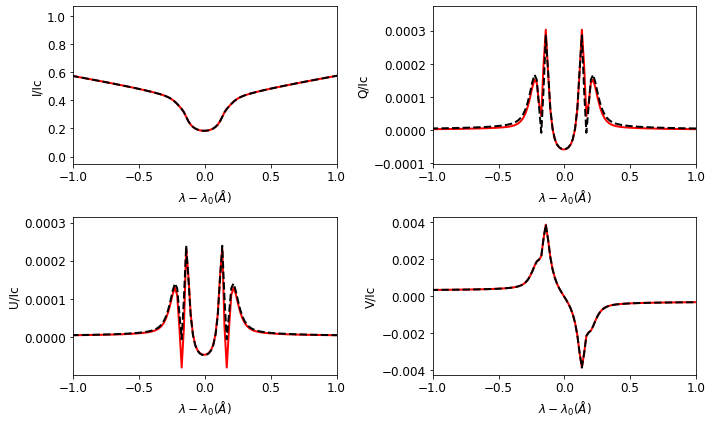

In [25]:
# Read Stokes spectra from both directories (with and without MO effects)

falc = rhanalyze.rhout(rhoutput) 
falc_noMO =  rhanalyze.rhout(rhoutput_noMO)

lam = falc.spectrum.waves * 10 # convert to angstroms
lam_noMO = falc_noMO.spectrum.waves *10

# Get the continuum intensity for one of the Stokes I spectra 
# (it's just for normalizing, and it should be almost identical in both cases)
idx_cont = (np.abs(lam - wl_cont)).argmin()
Icont = falc.rays[0].I[idx_cont]

###### FIGURE: Plot the Stokes I, Q, U and V as a function of wavelength

fig, ax = plt.subplots(2,2, figsize = (10,6))
ax[0,0].set_ylabel('I/Ic')
ax[0,1].set_ylabel('Q/Ic')
ax[1,0].set_ylabel('U/Ic')
ax[1,1].set_ylabel('V/Ic')
for kk in range(2):
    for jj in range(2):
        ax[jj, kk].set_xlabel(r'$\lambda -\lambda_0 (\AA)$')
        ax[jj, kk].set_xlim(-1, 1)
        ax[jj, kk].locator_params(axis="x", nbins=4)

ax[0,0].plot(lam-lam0, falc.rays[0].I/Icont,'r-', linewidth=2.0)
ax[0,0].plot(lam_noMO-lam0, falc_noMO.rays[0].I/Icont, 'k--',linewidth=2.0)

ax[0,1].plot(lam-lam0, falc.rays[0].Q/Icont,'r-', linewidth=2.0)
ax[0,1].plot(lam_noMO-lam0, falc_noMO.rays[0].Q/Icont, 'k--',linewidth=2.0)

ax[1,0].plot(lam-lam0, falc.rays[0].U/Icont, 'r-',linewidth=2.0)
ax[1,0].plot(lam_noMO-lam0, falc_noMO.rays[0].U/Icont, 'k--',linewidth=2.0)

ax[1,1].plot(lam-lam0, falc.rays[0].V/Icont,'r-', linewidth=2.0)  
ax[1,1].plot(lam_noMO-lam0, falc_noMO.rays[0].V/Icont, 'k--',linewidth=2.0)  

plt.tight_layout()

<h2> Calculate azimuth in the POS</h2>

Using the WFA:

$\frac{U}{Q} = \tan 2\chi$

Essentially, we have to perform a linear fit of Stokes U to Stokes Q. The slope of the linear fit should equal 2 times the tangent of the azimuth.

We will do this in the core and the wing of the spectral line separately. You can play with the wavelength ranges and look at what happens.

In [16]:
# Define two wavelength ranges to apply the WFA
# line wing on the blue side, in Angstroms
wl1 = 8530
wl2 = 8541
# core of the line, half an Angs to each side
wl1core = 8541.0 #8541.9
wl2core= 8542.09


In [28]:

# Read the outputs for the two runs (with and without MO effects)
falc = rhanalyze.rhout(rhoutput) 
falc_noMO =  rhanalyze.rhout(rhoutput_noMO)

# Extract I,Q,U,V in the wing and the core of the line for each case

#### Case WITH M-O effects
lam = falc.spectrum.waves*10. # convert from nm to Angs
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2)) 
indcore = np.argwhere(np.logical_and(lam>=wl1core, lam<=wl2core)) 

# Line wing
I = falc.rays[0].I[indlam]/Icont
Q = falc.rays[0].Q[indlam]/Icont
U = falc.rays[0].U[indlam]/Icont
V = falc.rays[0].V[indlam]/Icont
#Line core
Ic = falc.rays[0].I[indcore]/Icont
Qc = falc.rays[0].Q[indcore]/Icont
Uc = falc.rays[0].U[indcore]/Icont
Vc = falc.rays[0].V[indcore]/Icont

#### Case WITHOUT M-O effects
lam_noMO = falc.spectrum.waves*10. # convert from nm to Angs
indlam = np.argwhere(np.logical_and(lam_noMO>=wl1, lam_noMO<=wl2)) 
indcore = np.argwhere(np.logical_and(lam_noMO>=wl1core, lam_noMO<=wl2core)) 

# Line wing
I_noMO = falc_noMO.rays[0].I[indlam]/Icont
Q_noMO = falc_noMO.rays[0].Q[indlam]/Icont
U_noMO = falc_noMO.rays[0].U[indlam]/Icont
V_noMO = falc_noMO.rays[0].V[indlam]/Icont
# Line core 
Ic_noMO = falc_noMO.rays[0].I[indcore]/Icont
Qc_noMO = falc_noMO.rays[0].Q[indcore]/Icont
Uc_noMO = falc_noMO.rays[0].U[indcore]/Icont
Vc_noMO = falc_noMO.rays[0].V[indcore]/Icont


#### Perform a linear fit between U and Q. Check the value of the intercept!


beta_wing = P.polyfit(np.squeeze(Q), np.squeeze(U), 1)
beta_core = P.polyfit(np.squeeze(Qc), np.squeeze(Uc), 1)
beta_noMO = P.polyfit(np.squeeze(Q_noMO), np.squeeze(U_noMO), 1)
beta_noMO_core = P.polyfit(np.squeeze(Qc_noMO), np.squeeze(Uc_noMO), 1)

chi_wing = 1/2. * np.arctan(beta_wing[1])*180./np.pi
chi_core = 1/2. * np.arctan(beta_core[1])*180./np.pi
chi_noMO = 1/2. * np.arctan(beta_noMO[1])*180./np.pi
chi_noMO_core = 1/2. * np.arctan(beta_noMO_core[1])*180./np.pi

print('--- Original model azimuth:')
print('    Chi = ', chi_mod, ' deg')
print()

print('--- With M-O effects:')
print('    LINE WING: WFA azimuth = ' + format(chi_wing, '3.1f')+ ' deg')
print('    LINE CORE: WFA azimuth = ' + format(chi_core, '3.1f')+ ' deg')
print('')

### For the case WITHOUT M-O effects

print('--- Without M-O effects:')
print('    LINE WING: WFA azimuth = ' + format(chi_noMO, '3.1f')  +' deg')
print('    LINE CORE: WFA azimuth = ' + format(chi_noMO_core, '3.1f')+' deg')

--- Original model azimuth:
    Chi =  20.0  deg

--- With M-O effects:
    LINE WING: WFA azimuth = 25.0 deg
    LINE CORE: WFA azimuth = 17.2 deg

--- Without M-O effects:
    LINE WING: WFA azimuth = 20.0 deg
    LINE CORE: WFA azimuth = 20.0 deg


<h2> Kawakami diagrams </h2>

Why is the azimuth obtained through the WFA innacurate when M-O effects are present? The WFA assumes there is a linear relationship between Q and U. If you plot one against the other (this is a Kawakami diagram), you will see that this is not the case when M-O effects are present.



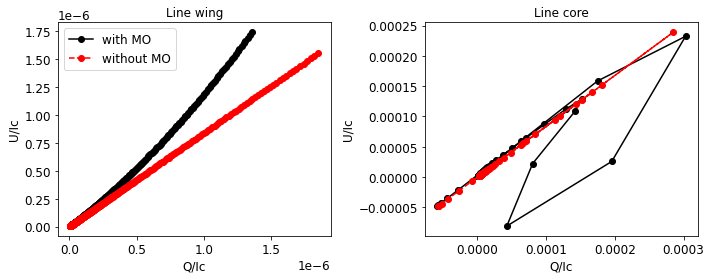

In [27]:
fig, ax = plt.subplots(1,2, figsize = [10,4])
ax[0].plot(Q, U, 'ko-', label='with MO')
ax[0].plot(Q_noMO, U_noMO, 'ro--', label = 'without MO')
ax[0].set_title('Line wing')

ax[1].plot(Qc, Uc, 'ko-')
ax[1].plot(Qc_noMO, Uc_noMO, 'ro--')

ax[1].set_title('Line core')

for jj in range(2):
    ax[jj].set_xlabel('Q/Ic')
    ax[jj].set_ylabel('U/Ic')
ax[0].get_legend_handles_labels
ax[0].legend()
plt.tight_layout()